In [1]:
# 1. batch_size :  The number of samples to train use in one iteration
# 2. epochs : The number of times the network goes through the enitre training dataset.
# 3. Sample_size : [speculation] The number of images[random noise] used in training for generator.
# 4. nz :[speculation] input feature size for each sample[image] in above sample_size.
# 5. k : hyper-parameter
# 6. device : utilizing GPU if available 

## Dependencies

1. Tqdm :  provides progress bar.
2. Transform : provides common image transform algorithms.
3. make_grid : Make a grid of images.
4. DataLoader: helps in importing training and test sets 

In [2]:
import torch 
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)


Tensor:

    1. Tensors are n-dimnesional matrix or vertices.
    2. Pytorch use tensor operations.

Batches:

    1. Batches are the amount of training samples the model performs operation during a single execution.
    2. Batch values are usually chosen to be multiples of 2 (32,64,128,256,512).

Sumamry :
    1. https://stackoverflow.com/questions/42480111/model-summary-in-pytorch

# Dataset

    1. The Dataset is downloaded from the MNIST website . Furtherthe data is divided
       into batches , converted from PIL to tensors using DataLoaders.
    2. Dataloader encloses a iterable wrapper over the tensor object using which we
       can access each batch.
    3. Structure : 469 batches -> each containg 128 images -> each image  [1,28,28]

In [3]:
loss_func = nn.BCEWithLogitsLoss()
epochs = 200
batch_size = 128
lr = 0.0001
z_dim = 64
device = 'cuda'

In [4]:
dataloader = DataLoader( MNIST("/work/basicGAN/GAN_cadmus/input",download = False,transform = transforms.ToTensor() )
                ,batch_size = batch_size , shuffle = True)

/shared-libs/python3.7/py/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
def display_image(tensor_image,num_img = 25):

    tensor_image = tensor_image.view(tensor_image.shape[0],1,28,-1)
    image_grid = make_grid(tensor_image[0:25],nrow =5)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()

### The Generator

batch norm - batch normalization lagta hai har ek feature pe ya column pe. Toh usko bas columns chahiye as argument. 
Ab gan generator kam hai ki bas layout prepare kare , isse input featurs aur output features set ho jaate hai . Baaki num of sample baadmai pass karne ke time bhejna hota hai. yaha pe 10 feature ke vector ko humne 28*28 pe scale kar diya,

In [6]:
def create_gan_layer(input_dim,output_dim):
    
    return nn.Sequential(

        nn.Linear(input_dim,output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = False)
    )

In [7]:
class Generator(nn.Module):

    def __init__(self,z_dim,hidden_dim,image_dim):

        super(Generator,self).__init__()

        self.gen = nn.Sequential(

            create_gan_layer(z_dim,hidden_dim),
            create_gan_layer(hidden_dim,hidden_dim*2),
            create_gan_layer(hidden_dim*2,hidden_dim*4),
            create_gan_layer(hidden_dim*4,hidden_dim*8),

            nn.Linear(hidden_dim*8,image_dim),
            nn.Sigmoid()
        )
    
    def forward(self,noise):
        return self.gen(noise)

Here  the intial linear defintion is just a intialization which creates the structure of the model . This is just for one iamge it ignore the batch_size or all the input samples. 
Calling the model by passing input with batch size to the variable it is assigned to during declaration . here it is gen(noise). Forward acts as the calling function once the object is created.
https://stackoverflow.com/questions/54916135/what-is-the-class-definition-of-nn-linear-in-pytorch

### Creating&nbsp;Noise&nbsp;Generator

In [8]:
def noise_generator(num_samples,z_dim,device):

    return torch.randn(num_samples,z_dim,device = device)

### The Discriminator

1. The create discriminator block is used for creating a layer with leaky relu having slope 0.2.
2. The Discriminator inherits nn.Module which acts as a base class for all nn Models.
3. It has three layers with leaky relu as the activation layer , but the last layer which predicts the single dimensional prediction has no activation function because we're using BCELogitloss which is a combination of Sigmoid and BCE loss.
4. An object is initialized using the constructor arguments  , later the object is passed with the input image which makes an implicit call to the forward function .
5. Input : 784 features ( pixels ).
   Hidden Dimensions : (784,512) --> (512,256) --> (256,128)
   Output : 1 [0/1] (fake/real image).


In [9]:
def create_disc_layer(input_dim,output_dim):

    return nn.Sequential(

        nn.Linear(input_dim,output_dim),
        nn.LeakyReLU(0.2,inplace=True)
    )

In [10]:
class Discriminator(nn.Module):

    def __init__(self,img_dim,hidden_dim,target_dim,device):

        super(Discriminator,self).__init__()
        
        self.disc = nn.Sequential(

            create_disc_layer(img_dim,hidden_dim*4),
            create_disc_layer(hidden_dim*4,hidden_dim*2),
            create_disc_layer(hidden_dim*2,hidden_dim),
            
            nn.Linear(hidden_dim,target_dim)
        )

    def forward(self,img):

        return self.disc(img) 

In [11]:
discriminator  = Discriminator(784,128,1,"cuda")

### The Loss Function

    1. Create a batch of real images , Create another batch of Fake (Generated) Images.
    2. Pass these to the discriminator object seperately and store them . These are the real and fake pred respectively.
    3. Get loss for both of the preds for discriminator and generator separately which means there will be four values . (real_disc_loss , fake_disc_loss , real_gen_loss , fake_gen_loss).
    4 . The loss function used is BCELogitloss which has two arguments (pred,target).
    5. Pred values are the ones we just obtained , the target values for this model is either a bunch of zeros or 1's based on whether the pred is real or fake.

![Picture title](image-20210625-115449.png)

Here the log dx part is the probability of real images being real and 1-logdx is fake being fake. 
Hence the classifier (Discriminator needs yo maximizre this) .

Whereas the generator wants the probability of fake images being fake to as low as possible hence it tries minimize the value.


As maximizing we need gradient ascent and as decreasing we need gradient descent . 
It doesn't use convergence because convergence is the end point we wnat our models to be in equilibrium.

    create noise
    generator image from noise , 
    get fake pred, get fake loss , 
    get real images , 
    get real pred , 
    get real loss , 
    disc loss by average

    get noise
    generate 
    get disc pred
    get loss but with required target


In [12]:
real,_ = iter(dataloader).next()
real = real.view(real.shape[0],-1)

In [13]:
bce = nn.BCEWithLogitsLoss()
z_dim = 10
hidden_dim = 128
img_dim = 784
device = 'cpu'
batch_size = real.shape[0]
gen = Generator( z_dim,hidden_dim,img_dim )
disc = Discriminator( img_dim,hidden_dim,1,device)

In [14]:
def get_disc_loss(real,num_samples,z_dim,device):

    noise = noise_generator(num_samples,z_dim,device)
    fake_img = gen(noise)
    fake_pred = disc(fake_img)
    fake_loss = bce(fake_pred,torch.zeros_like(fake_pred))

    real  = real
    real_pred = disc(real)
    real_loss = bce(real_pred,torch.ones_like(real_pred))

    return ( fake_loss + real_loss ) / 2

In [15]:
get_disc_loss(real,batch_size,z_dim,device)

tensor(0.6929, grad_fn=<DivBackward0>)

In [16]:
def get_gen_loss(num_samples,z_dim,device):

    noise = noise_generator(num_samples,z_dim,device)
    fake_img = gen(noise)
    fake_pred = disc(fake_img)
    gen_loss = bce(fake_pred,torch.ones_like(fake_pred))

    return gen_loss

In [17]:
get_gen_loss(batch_size,z_dim,device)

tensor(0.6550, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

### Final Model ( n-epochs )

1. Declare all the variables.
2. Outer loop for epochs.
3. Inner loop which iterates over batches in dataloader.
4. Batch_size --> disc_loss(curr_real_batch,z_dim).
5. zero grad before updating discriminator parameters.

In [18]:
lr = 0.00001
epochs = 200

In [19]:
gen_opt = torch.optim.Adam(gen.parameters(),lr = lr)
disc_opt = torch.optim.Adam(disc.parameters(),lr= lr)

In [20]:
def test_noise():

    print("I")
    noise_test = noise_generator(batch_size,z_dim,device)
    fake_img = gen(noise)

    real_img,_ = next(iter(dataloader))

    return disc_loss,gen_loss,
    display_image(fake_img,25),
    display_image(real_img,25)


0 disc_loss tensor(0.6931, grad_fn=<DivBackward0>) gen_loss tensor(0.6575, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


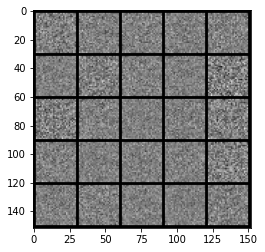

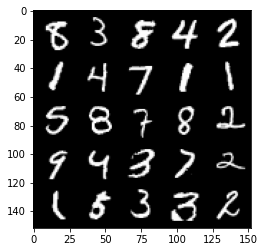

KeyboardInterrupt: 

In [21]:
for epoch in range(epochs):

    curr = 0
    for real,_ in dataloader:

        real = real.view(real.shape[0],-1)
        batch_size = real.shape[0]
        disc_opt.zero_grad()

        disc_loss = get_disc_loss(real,batch_size,z_dim,device)
        disc_loss.backward()
        disc_opt.step()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(batch_size,z_dim,device)
        gen_loss.backward()
        gen_opt.step()

        if curr % 100 == 0 :
          noise_test = noise_generator(batch_size,z_dim,device)
          fake_img = gen(noise_test)

          print(curr,"disc_loss",disc_loss,"gen_loss",gen_loss)
          display_image(fake_img,25),
          display_image(real,25)

        curr += 1

    

https://stackoverflow.com/questions/49420459/what-is-the-ideal-value-of-loss-function-for-a-gan

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a5eebfae-950c-452c-bcd1-02b41e6a5850' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>